In [1]:
from fastai.vision.all import *
from kornia import rgb_to_grayscale
import torch.nn as nn
import warnings
import random, textwrap
import os, glob
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from skimage.util import random_noise
from skimage import util
from skimage import exposure
from scipy import ndimage
from datetime import datetime
warnings.filterwarnings("ignore", category=DeprecationWarning)

np.random.seed(42)
torch.manual_seed(42)
log = True

In [2]:
def plot_filters_multi_channel(t, path=''):

    #get the number of kernels
    num_kernels = t.shape[0]

    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels

    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))

    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)

        #for each kernel, we convert the tensor to numpy
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.tight_layout()
    if path != '':
        plt.savefig(path)
    plt.show()

## TRANSFORMATIONS
def no_trans(base):
    return base

# random noise
def rnd_noise(base):
    original_image = np.array(base).astype('uint8')
    base_noise = random_noise(original_image)
    return Image.fromarray(np.uint8(base_noise*255))

# color inversion
def col_inv(base):
    original_image = np.array(base).astype('uint8')
    base_inv = np.invert(original_image)
    return Image.fromarray(np.uint8(base_inv))

# contrast correction
def cont_corr(base):
    original_image = np.array(base).astype('uint8')
    v_min, v_max = np.percentile(original_image, (15, 85))
    base_contr = exposure.rescale_intensity(original_image, in_range=(v_min, v_max))
    return Image.fromarray(np.uint8(base_contr))

# gamma correction
def gamma_corr(base):
    original_image = np.array(base).astype('uint8')
    base_gamma = exposure.adjust_gamma(original_image, gamma=0.4, gain=0.9)
    return Image.fromarray(np.uint8(base_gamma))

# log correction
def log_corr(base):
    original_image = np.array(base).astype('uint8')
    base_log = exposure.adjust_log(original_image)
    return Image.fromarray(np.uint8(base_log))

# horizontal flip
def hflip(base):
    original_image = np.array(base).astype('uint8')
    base_hflip = original_image[:, ::-1]
    return Image.fromarray(np.uint8(base_hflip))

# blur
def blur(base):
    original_image = np.array(base).astype('uint8')
    base_blur = ndimage.uniform_filter(original_image, size=(10, 10, 1))
    return Image.fromarray(np.uint8(base_blur))

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # V1 layers
        self.V1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=7 // 2),  # + self.vfb,
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # V2 layers
        self.V2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # V4 layers
        self.V4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # IT layers
        self.IT = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=3 // 2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        # decoding layer
        self.decoder = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(), nn.Linear(512, 4),
        )

    def forward(self, inp):

        # v4 = torch.zeros(512, 256, 3, 3).to("cuda")
        # vIT = torch.zeros(256, 128, 3, 3).to("cuda")
        # v2 = torch.zeros(256, 128, 3, 3).to("cuda")
        # v1 = torch.zeros(128, 64, 3, 3).to("cuda")
        x = inp.to("cuda")

        v1 = self.V1(x).to("cuda")
        v2 = self.V2(v1).to("cuda")
        v4 = self.V4(v2).to("cuda")
        vIT = self.IT(v4).to("cuda")
        out = self.decoder(vIT).to("cuda")

        return out

def show_images(before, after):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    ax = axes.ravel()
    ax[0].imshow(before, cmap='gray')
    ax[0].set_title("Original image")

    ax[1].imshow(after, cmap='gray')
    ax[0].axis('off')
    ax[1].axis('off')
    plt.tight_layout()

def label_from_path(path):
    split_name = path.stem.split("_")
    return split_name[-1][0]

def display_images(
    images: [Image.Image],
    columns=5, width=20, height=8, max_images=15,
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        plt.axis('off')
        plt.tight_layout()

        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size);

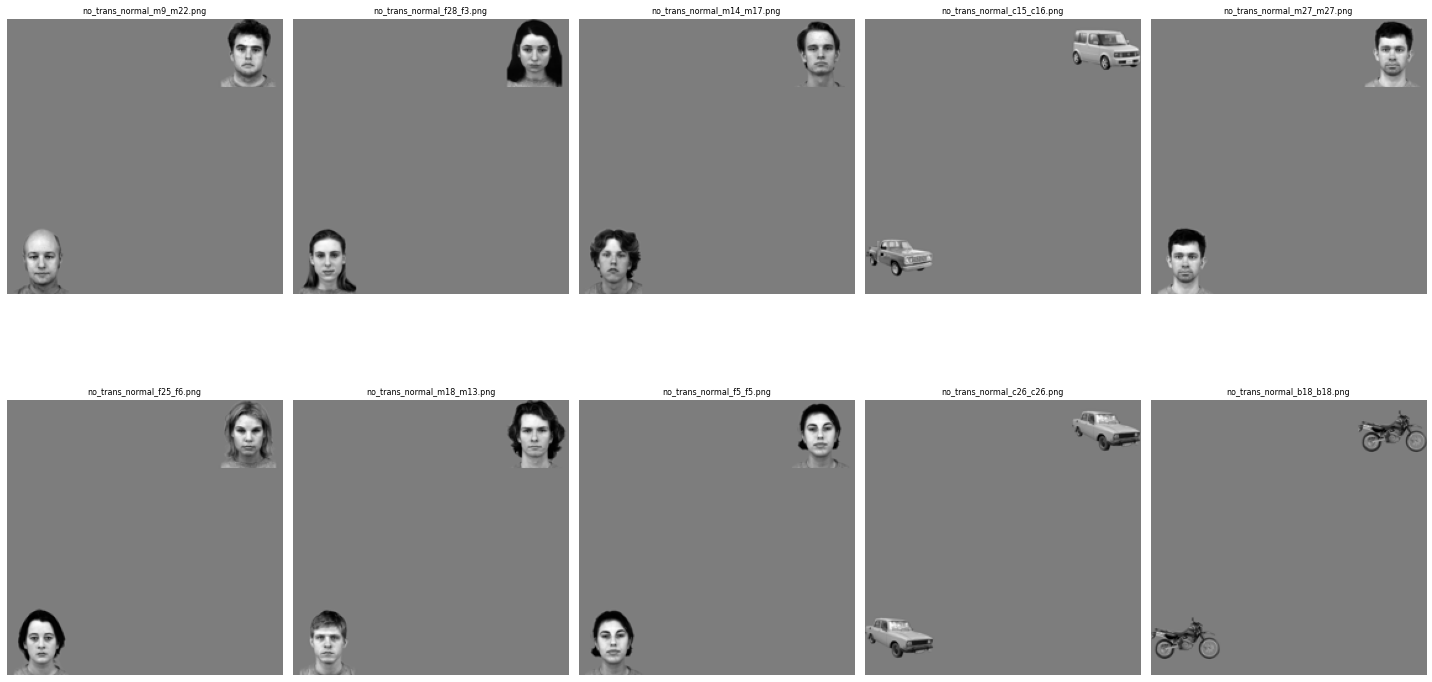

In [3]:
stim_path = r'C:\Users\45027900\Desktop\model_old\data\original\samediff\base'

pairs = glob.glob(os.path.join(stim_path, '*.png'))
display_images([Image.open(i) for i in random.sample(pairs, 10)])


Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck

Showing first batch...
TRAIN SET (bike, car, female, male): 48, 48, 48, 48
TEST SET (bike, car, female, male): 12, 12, 12, 12


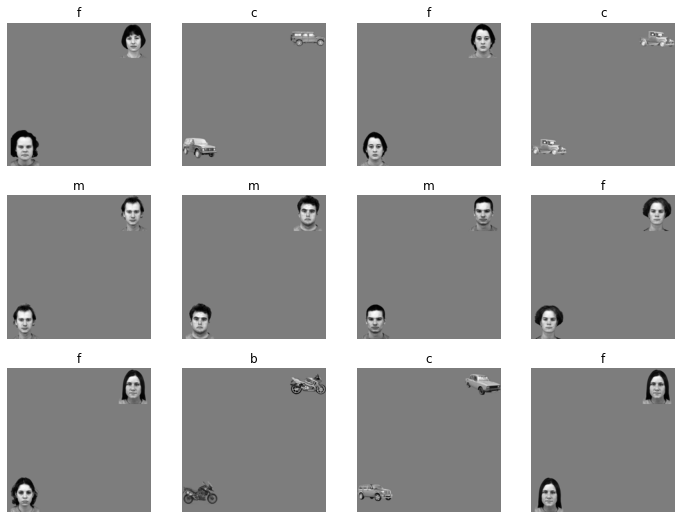

In [4]:
# init dataloaders
batch_sz = 12
stim_path = Path(stim_path)
fnames = sorted(Path(p) for p in pairs)
y = [label_from_path(item) for item in fnames]
dls = ImageDataLoaders.from_path_func(stim_path, fnames, label_from_path, valid_pct=0.2, seed=4, shuffle=True, stratify = y, device='cuda:0', bs=batch_sz)
# NOTE: if you want to change the splitter function for train/test open
# C:\Users\45027900\Anaconda3\envs\PyTorch\Lib\site-packages\fastai\vision\data.py
# and change splitter in ImageDataLoaders.from_path_func
# now the splitter is: TrainTestSplitter(test_size = valid_pct, random_state=seed, shuffle=shuffle) from sklearn
dls.num_workers = -1
print('\nShowing first batch...')
dls.show_batch(max_n = batch_sz)

# check that train and test splits have balanced classes
train_test = ['TRAIN','TEST']
for train_test_id in [0, 1]:
    c = 0
    f = 0
    m = 0
    b = 0
    for item in dls.__getitem__(train_test_id).items:
        #print(label_from_path(item))
        #print(item)
        #print('---')
        if label_from_path(item) == 'c':
            c += 1
        elif label_from_path(item) == 'f':
            f +=1
        elif label_from_path(item) == 'm':
            m +=1
        else:
            b += 1
        #print(item)
        #print(label_from_path(item))
        #print('--')
    print(f'{train_test[train_test_id]} SET (bike, car, female, male): {str(b)}, {str(c)}, {str(f)}, {str(m)}')

In [5]:
## init net and pass one image
net = Net().cuda()
#weights_path = Path(r"C:\Users\45027900\Desktop\project\net.pt")

#if weights_path.is_file():
#    ckpt_data = torch.load(weights_path)
#    state_dict = ckpt_data
#    state_dict.pop("FB.0.weight")
#    state_dict.pop("FB.0.bias")
#    state_dict["decoder.2.weight"] = torch.rand((2, 512))
#    state_dict["decoder.2.bias"] = torch.rand((2))
#    net.load_state_dict(state_dict)
#    print('weights loaded!')

image = dls.one_batch()[0][0].unsqueeze(0)
net(image).shape

torch.Size([1, 4])

In [6]:
#init learner
def split_layers(model):
    return [params(model.V1),params(model.V2),params(model.V4),params(model.IT), params(model.decoder)]

learner = Learner(dls, net, metrics=accuracy, loss_func=CrossEntropyLossFlat(), opt_func=Adam, splitter=split_layers)
learner.unfreeze()
learner.summary()

Net (Input shape: 12)
Layer (type)         Output Shape         Param #    Trainable 
                     12 x 64 x 112 x 112 
Conv2d                                    9472       True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     12 x 128 x 56 x 56  
Conv2d                                    73856      True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     12 x 256 x 28 x 28  
Conv2d                                    295168     True      
ReLU                                                           
MaxPool2d                                                      
__________________________________________________________

C:\Users\45027900\Anaconda3\envs\PyTorch\lib\site-packages\fastai\callback\schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


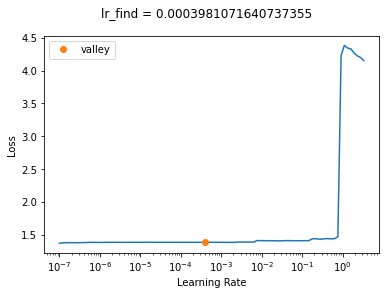

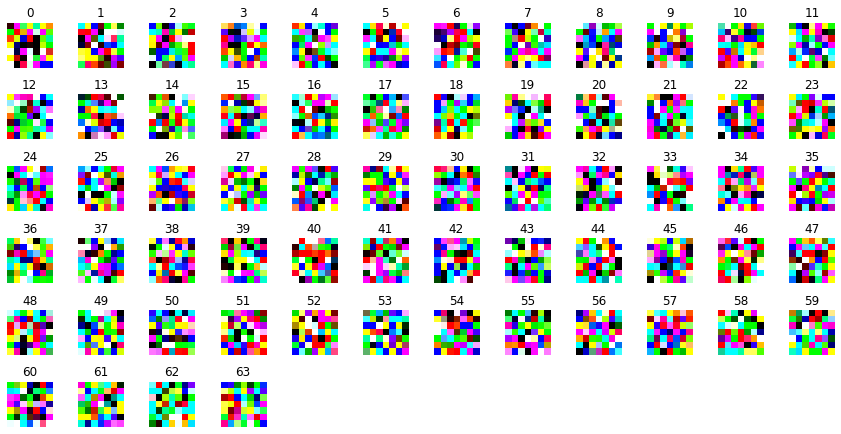

In [7]:
## SET LEARNING RATE PARAMS (ONE CYCLE POLICY), TRAIN AND PLOT LR AND ACC
# this gives us the best learning rate. see https://github.com/sgugger/Deep-Learning/blob/master/Understanding%20the%20new%20fastai%20API%20for%20scheduling%20training.ipynb

# define the output folder for figures
timestamp = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")
root = r'C:\Users\45027900\Desktop\project\chk\fastai'
run_name = 'CAT-TASK_basestim_val-20_adam_lr-find_10x5000'
if run_name != '':
    path = os.path.join(root,timestamp+ f'_{run_name}')
else:
    path = os.path.join(root,timestamp)
if log:
    os.makedirs(path, exist_ok=True)

metrics_dict = {'train_loss':[],'valid_loss':[],'accuracy':[]}

# define variables for the fit_one_cycle call 
n_epoch = 5000
div = 10
moms=(0.95, 0.85, 0.95)

#lr_max = 0.001
lr_max = learner.lr_find()[0]
plt.suptitle(f'lr_find = {lr_max}')
if log:
    plt.savefig(os.path.join(path,'lr_find.png'))
plt.show()

## USE THIS TO LOAD PREVIOUS CHECKPOINT
#learner.load(os.path.join(path, '05-Oct-2021_22-34-41_EPOCH-1x3000_fastai.pth'))

weights_start = learner.model.V1[0].weight.data.cpu()
fig_path = os.path.join(path,'weights_start.png')
if log:
    plot_filters_multi_channel(weights_start, path = fig_path)
else:
    plot_filters_multi_channel(weights_start)

EPOCH 1 - START - 20-Oct-2021_00-44-31


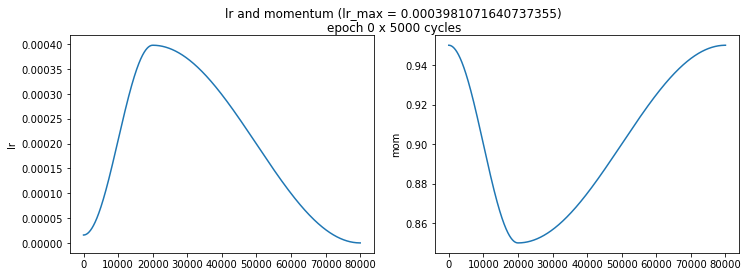

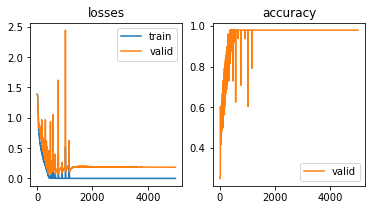

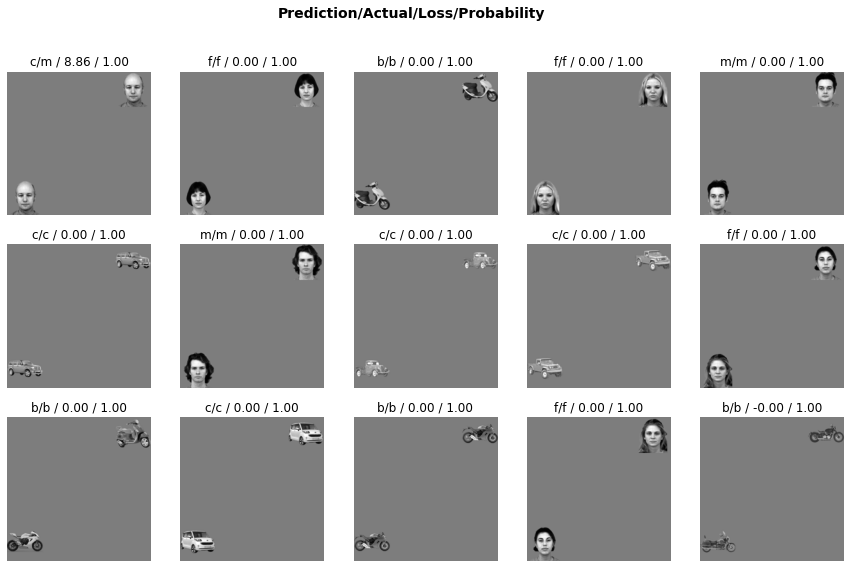

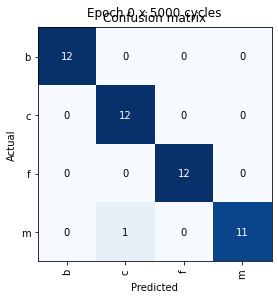

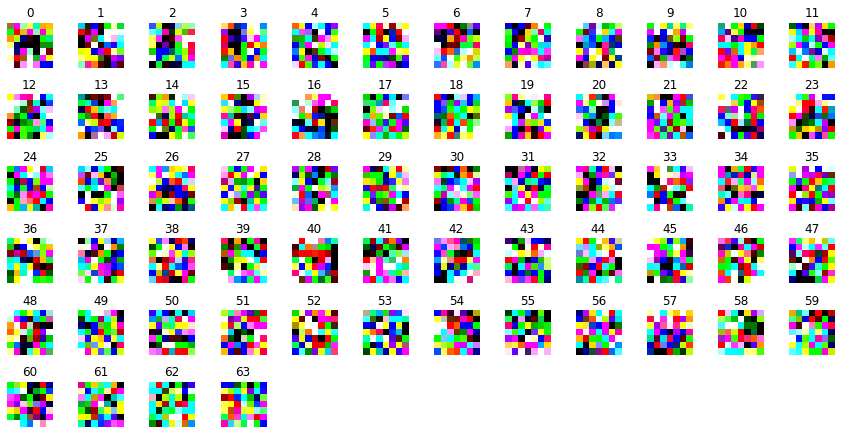

EPOCH 1 - END - 2021-10-20 01:58:00.097484
time: 1:13:28.949321
left: 11:01:20.543889
EPOCH 2 - START - 20-Oct-2021_00-44-31


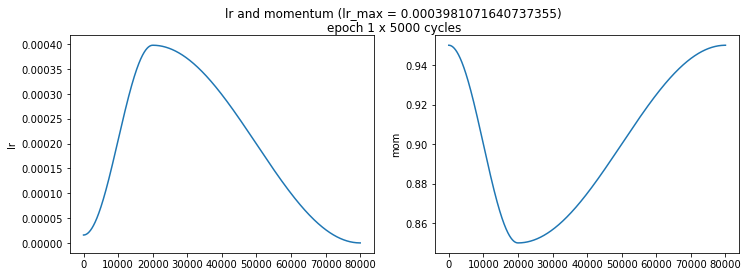

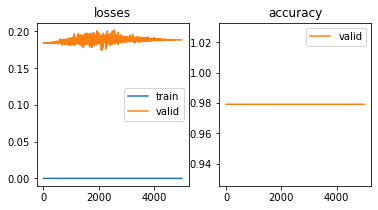

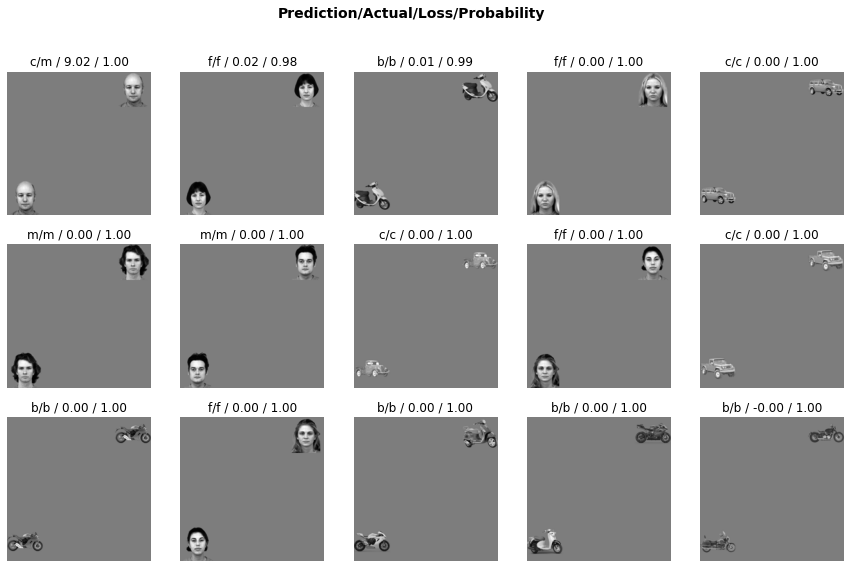

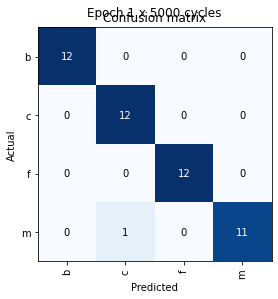

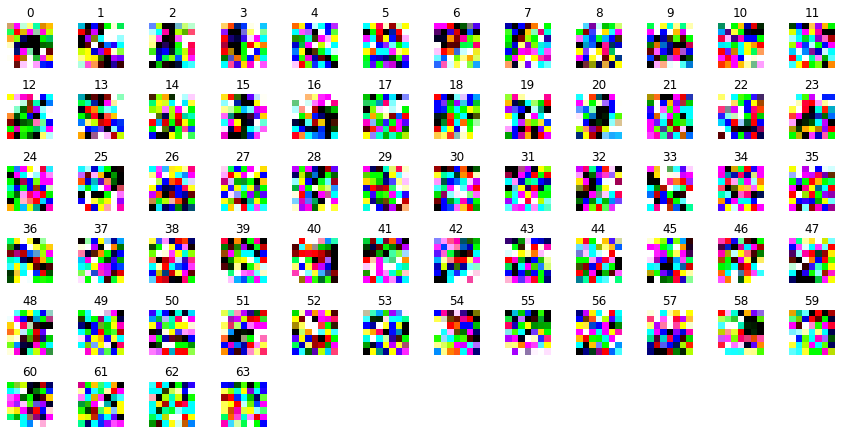

EPOCH 2 - END - 2021-10-20 03:11:28.154686
time: 1:13:28.057202
left: 9:47:44.457616
EPOCH 3 - START - 20-Oct-2021_00-44-31


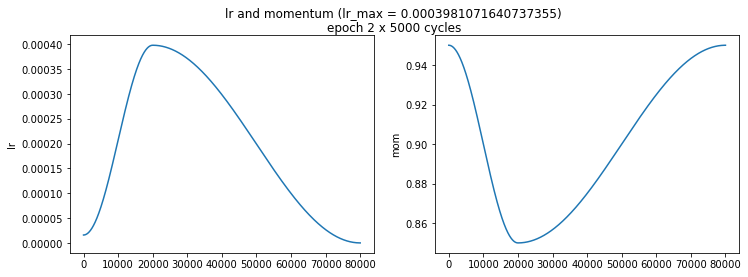

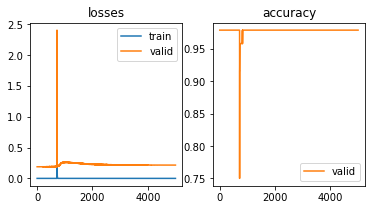

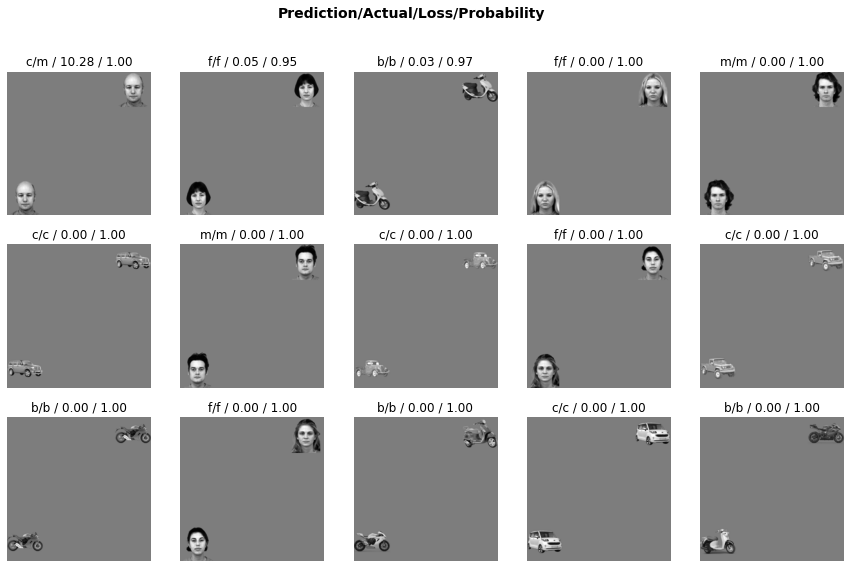

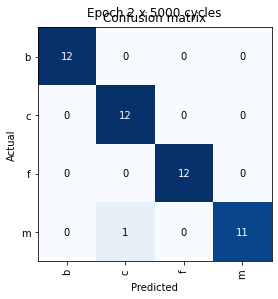

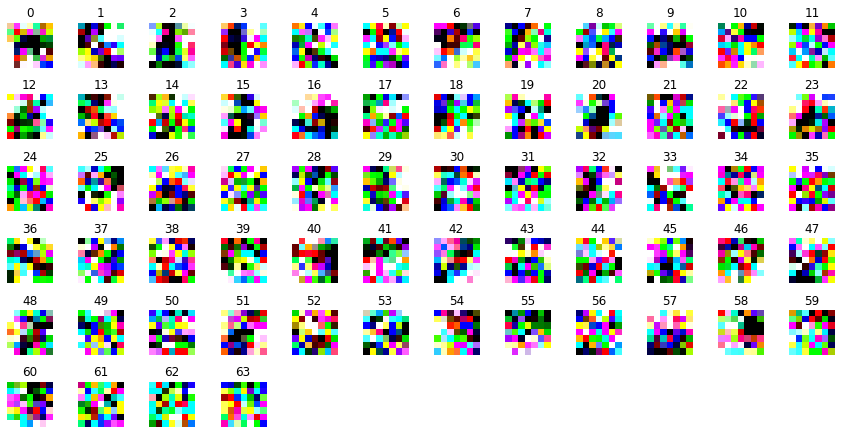

EPOCH 3 - END - 2021-10-20 04:24:49.477791
time: 1:13:21.323105
left: 8:33:29.261735
EPOCH 4 - START - 20-Oct-2021_00-44-31


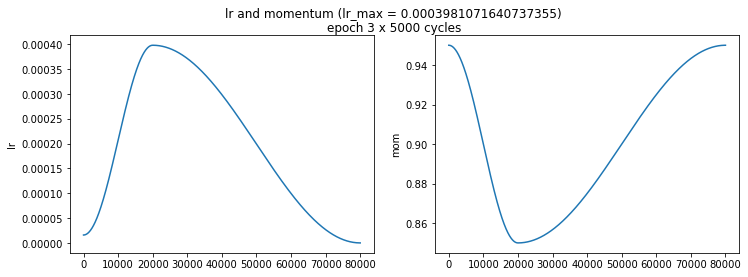

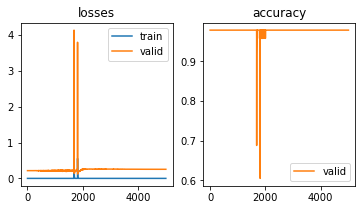

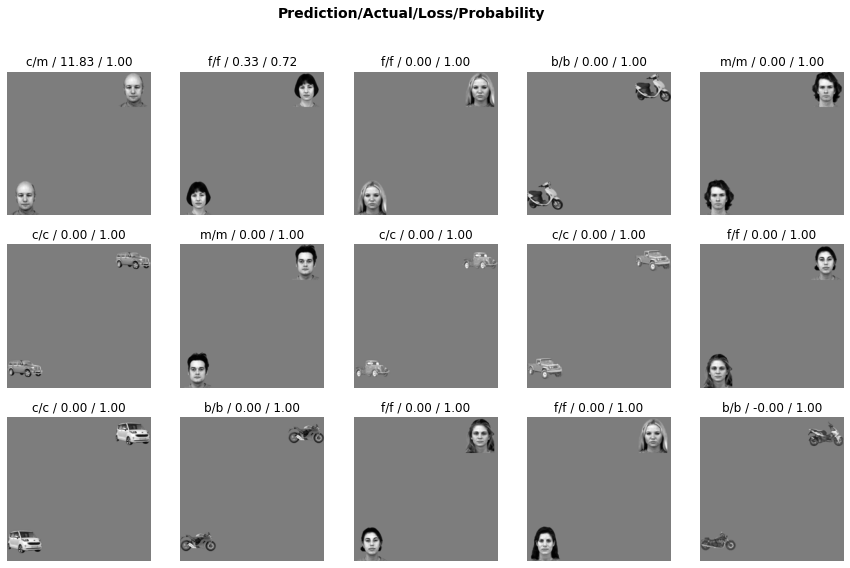

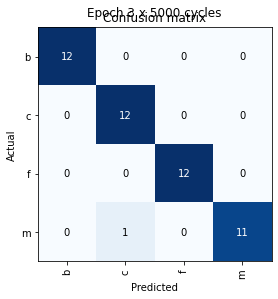

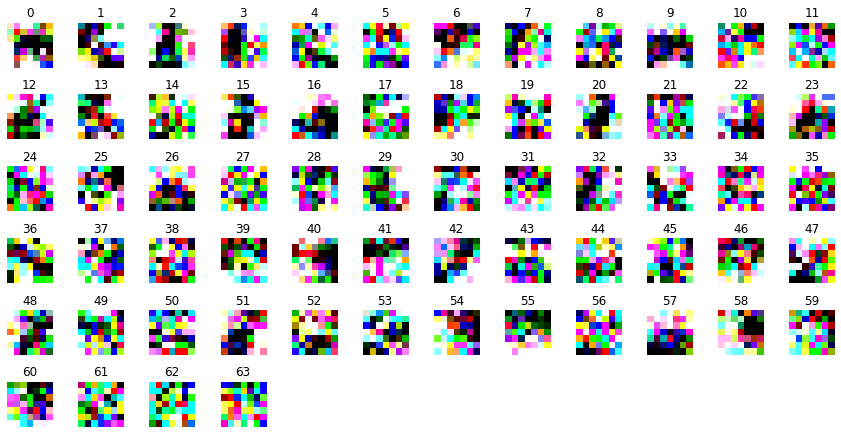

EPOCH 4 - END - 2021-10-20 05:37:41.384351
time: 1:12:51.906560
left: 7:17:11.439360
EPOCH 5 - START - 20-Oct-2021_00-44-31


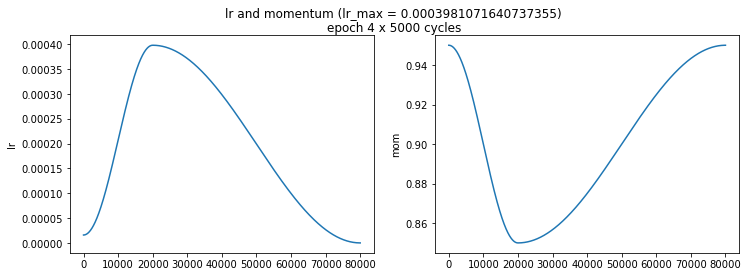

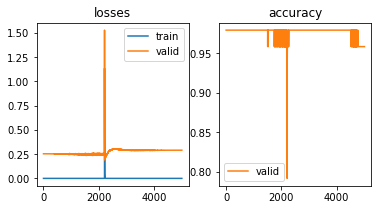

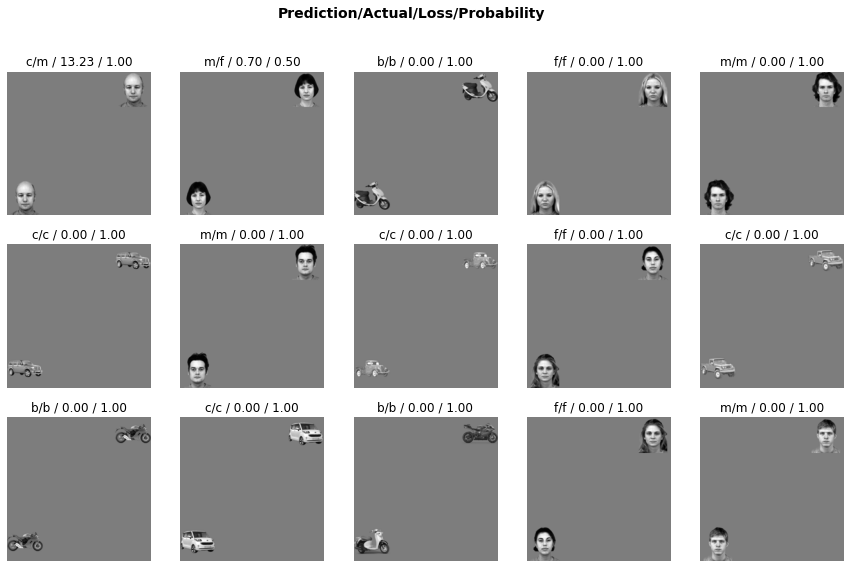

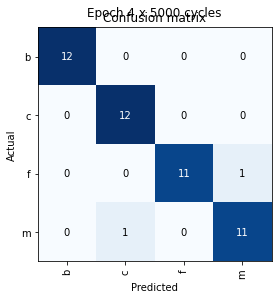

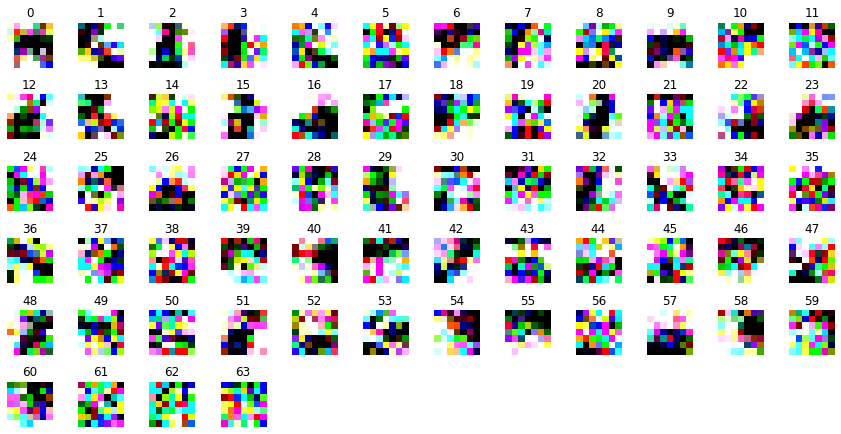

EPOCH 5 - END - 2021-10-20 06:50:11.317848
time: 1:12:29.933497
left: 6:02:29.667485
EPOCH 6 - START - 20-Oct-2021_00-44-31


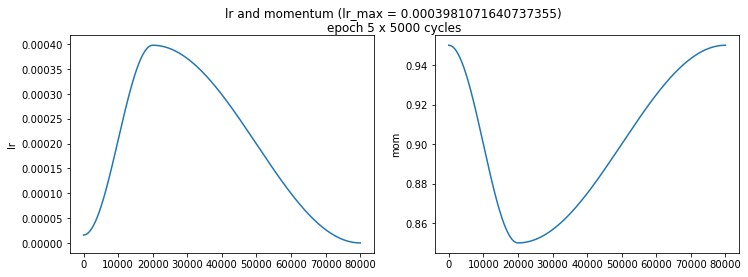

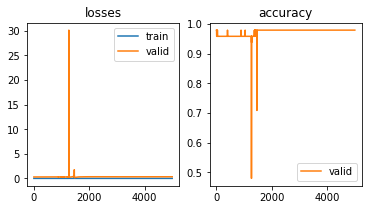

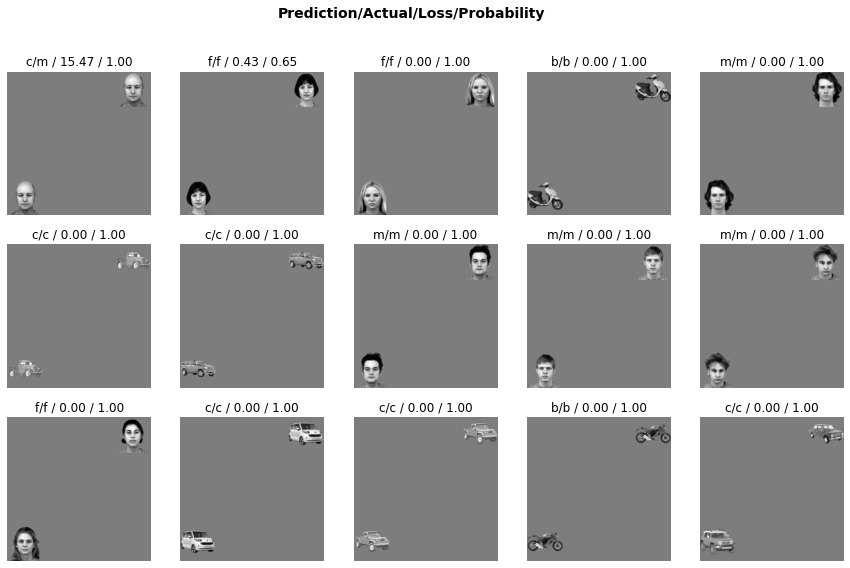

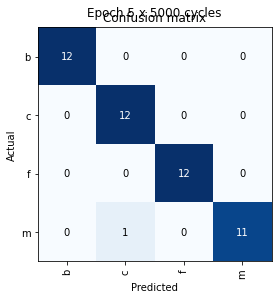

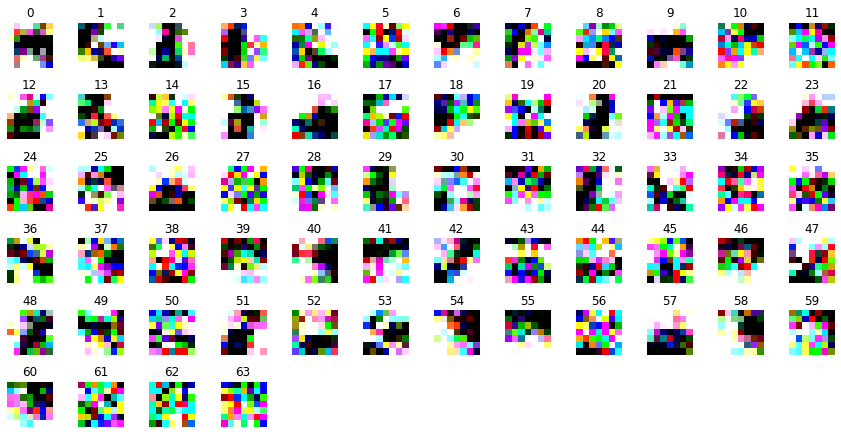

EPOCH 6 - END - 2021-10-20 07:59:56.534162
time: 1:09:45.216314
left: 4:39:00.865256
EPOCH 7 - START - 20-Oct-2021_00-44-31


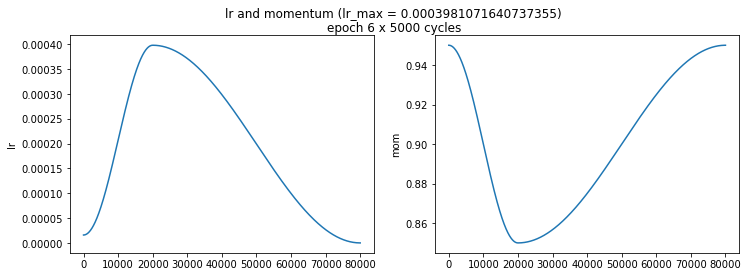

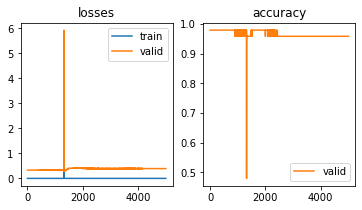

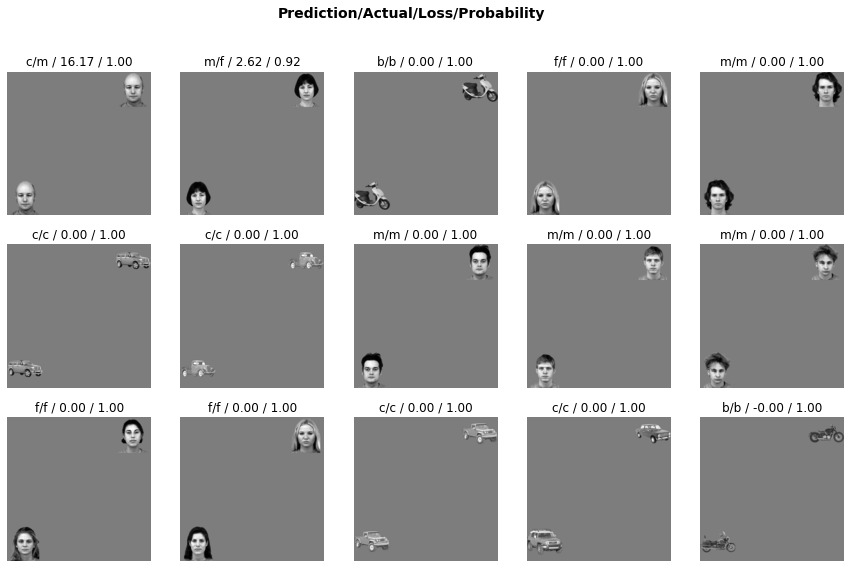

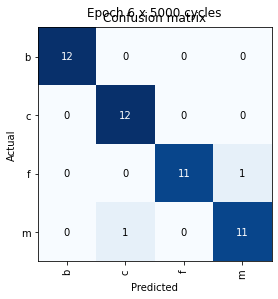

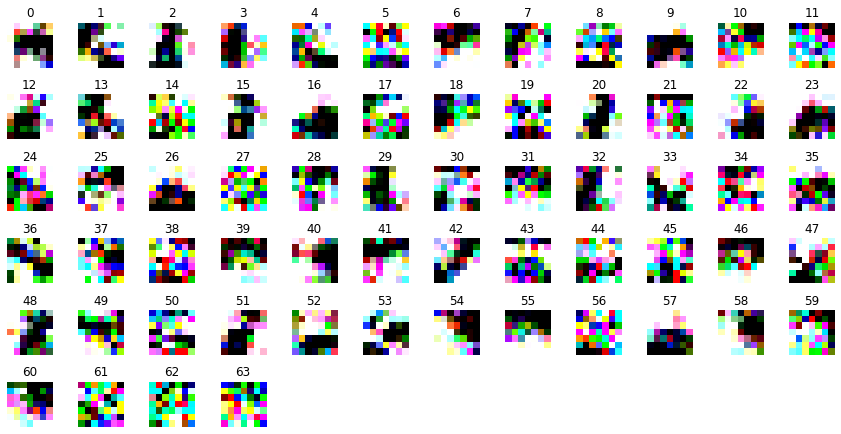

EPOCH 7 - END - 2021-10-20 08:53:57.777021
time: 0:54:01.242859
left: 2:42:03.728577
EPOCH 8 - START - 20-Oct-2021_00-44-31


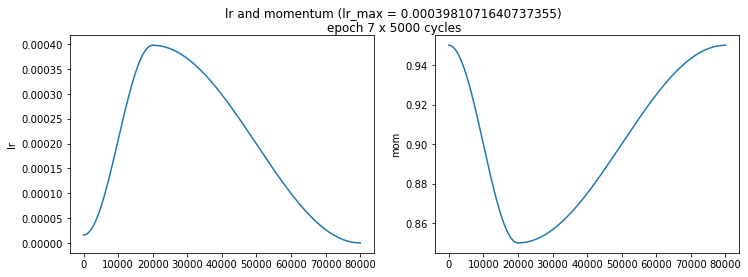

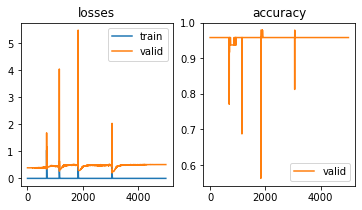

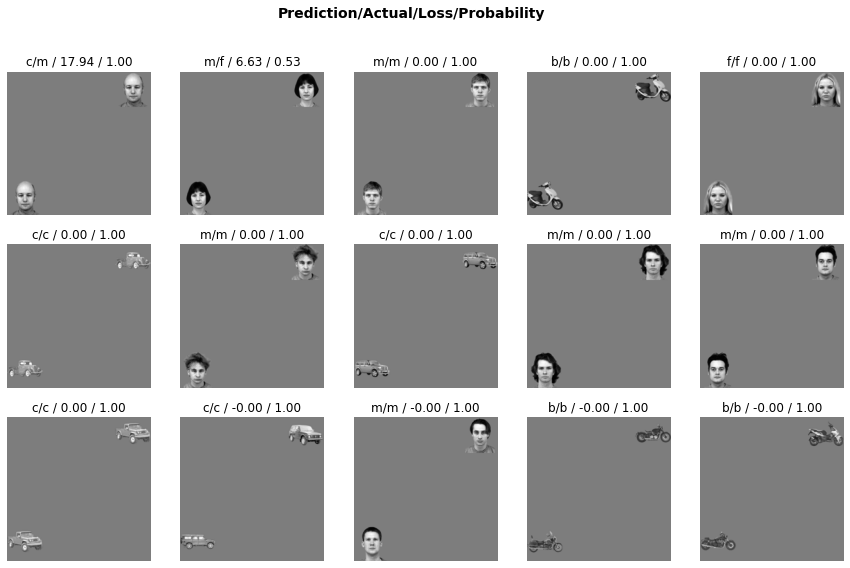

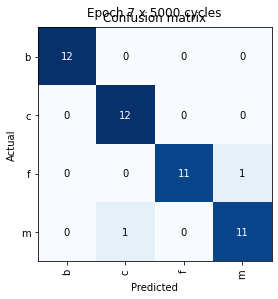

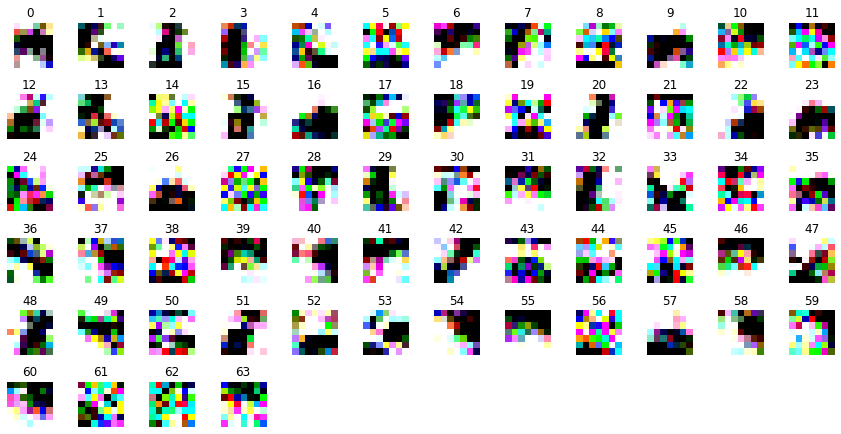

EPOCH 8 - END - 2021-10-20 09:42:52.110929
time: 0:48:54.333908
left: 1:37:48.667816
EPOCH 9 - START - 20-Oct-2021_00-44-31


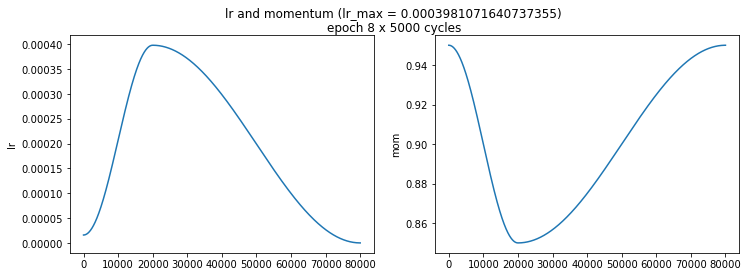

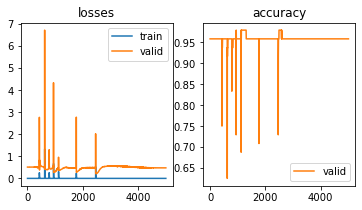

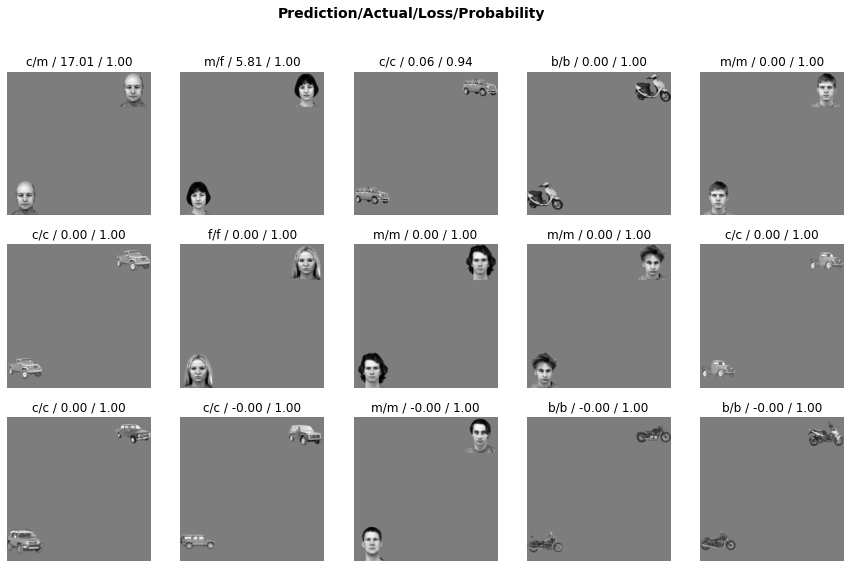

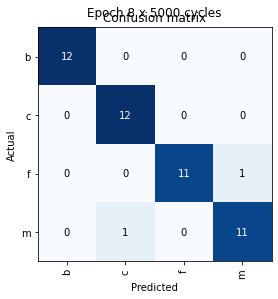

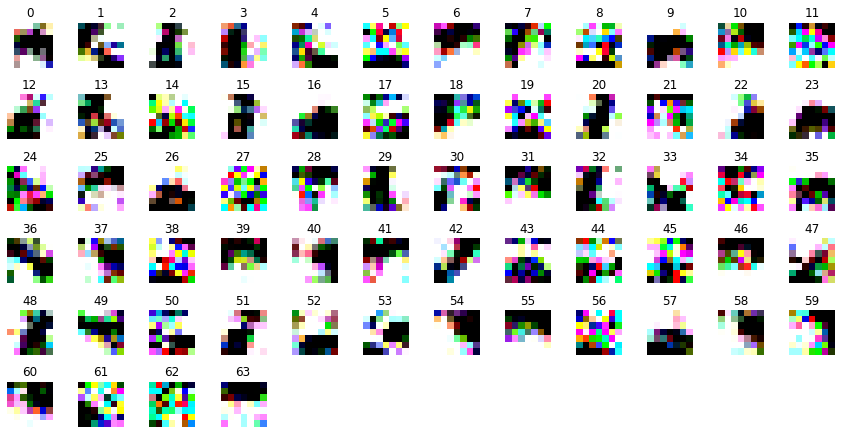

EPOCH 9 - END - 2021-10-20 10:30:14.975128
time: 0:47:22.864199
left: 0:47:22.864199
EPOCH 10 - START - 20-Oct-2021_00-44-31


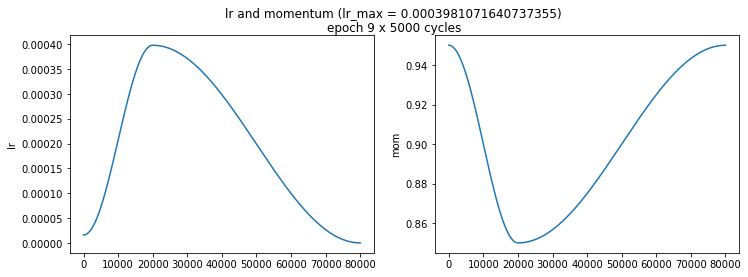

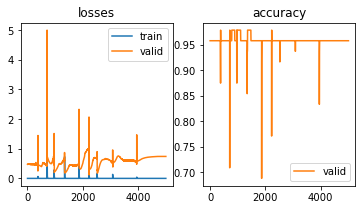

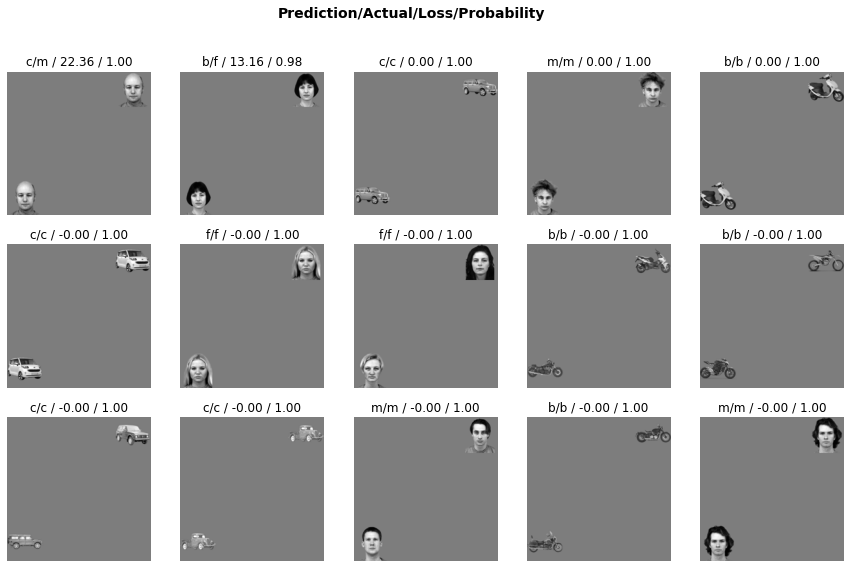

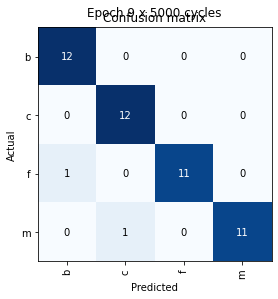

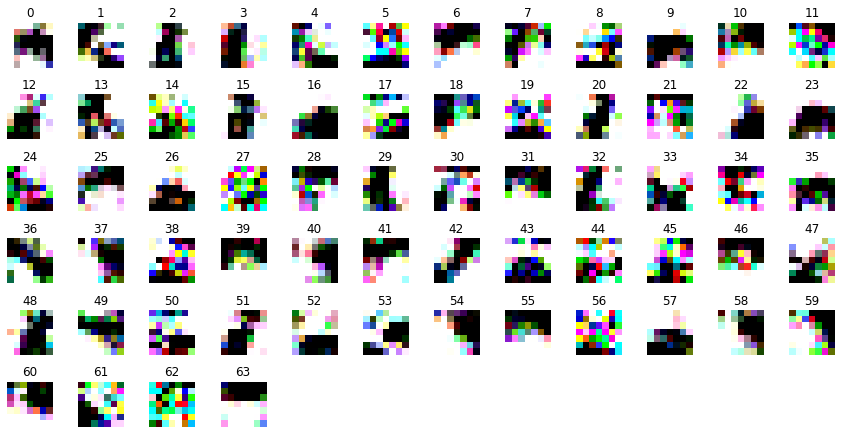

EPOCH 10 - END - 2021-10-20 11:17:46.401932
time: 0:47:31.426804
left: 0:00:00


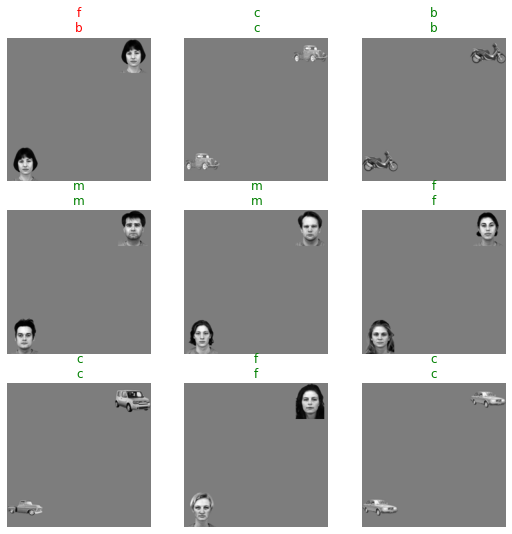

In [8]:
timestamp = datetime.now().strftime("%d-%b-%Y_%H-%M-%S")
epochs = 10
for epoch in range(epochs):
    with learner.no_logging(), learner.no_bar():
        # START
        start = datetime.now()
        print(f'EPOCH {str(epoch + 1)} - START - {timestamp}')

        # FIT
        learner.fit_one_cycle(n_epoch=n_epoch,lr_max=lr_max, moms=moms)#,div=div, cbs=EarlyStoppingCallback(monitor='valid_loss', min_delta=0.1, patience=10))

        # PLOT LEARNING RATE
        learner.recorder.plot_sched() # plot learning rate and mom
        plt.suptitle(f'lr and momentum (lr_max = {lr_max})\nepoch {epoch} x {n_epoch} cycles')
        if log:
            plt.savefig(os.path.join(path,f'lr_mom_{epoch}x{n_epoch}.png'))
        plt.show()

        # SAVE MODEL
        if log:
            file = os.path.join(path, f'{timestamp}_EPOCH-{epoch}x{n_epoch}_fastai')
            learner.save(file, with_opt=True, pickle_protocol=2)

        # SAVE AND PLOT METRICS
        i = 0
        for metric in learner.recorder.metric_names:
            if metric in metrics_dict.keys():
                metrics_dict[metric].append(learner.recorder.values[0][i])
                i =+ 1

        recorder = learner.recorder
        metrics =  np.stack(recorder.values)
        names = recorder.metric_names[1:-1]
        n = len(names) -1
        fig, axs = subplots(1, 2)
        axs = [ax if i < n else ax.set_axis_off() for i, ax in enumerate(axs.flatten())][:n]

        for i, (name, ax) in enumerate(zip(names, [axs[0]] + axs)):
                ax.plot(metrics[:, i], color='#1f77b4' if i == 0 else '#ff7f0e', label='valid' if i > 0 else 'train')
                ax.set_title(name if i > 1 else 'losses')
                ax.legend(loc='best')
        if log:
            plt.savefig(os.path.join(path,f'metrics_{epoch}x{n_epoch}.png'))

        interp = ClassificationInterpretation.from_learner(learner)
        interp.plot_top_losses(15)
        if log:
            plt.savefig(os.path.join(path,f'top-losses_{epoch}x{n_epoch}.png'))
            
        # PLOT CONFUSION MATRIX
        interp.plot_confusion_matrix()
        plt.suptitle(f'Epoch {epoch} x {n_epoch} cycles')
        if log:
            plt.savefig(os.path.join(path,f'confmat_{epoch}x{n_epoch}.png'))

        # PLOT WEIGHTS
        weights_end = learner.model.V1[0].weight.data.cpu()
        fig_path = os.path.join(path,f'weights_{epoch}x{n_epoch}.png')
        if log:
            plot_filters_multi_channel(weights_end, path = fig_path)
        else:
            plot_filters_multi_channel(weights_end)

        end = datetime.now()
        print(f'EPOCH {str(epoch + 1)} - END - {end}')
        print(f'time: {end-start}')
        if epochs > 1:
            print(f'left: {(end-start) * (epochs - 1 - epoch)}')

# PLOT RECENT RESULTS TO MAKE SURE THE LABELS ARE CORRECT
learner.show_results()
if log:
    plt.savefig(os.path.join(path,f'results_{epoch}x{n_epoch}.png'))

In [9]:
print(f'weights updated: {weights_start == weights_end}')

weights updated: tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]],

         [[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  .